In [ ]:
# ALCX Price vs Unique Holders
Based on Flipside Velocity query here: [link](https://app.flipsidecrypto.com/shareable/adoption-and-price-J6iI1y)

In [2]:
import urllib.request as rq
import json
from datetime import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

url = 'https://api.flipsidecrypto.com/api/v2/queries/4bf360e8-97ad-490f-b147-7024dffb139f/data/latest'

try:
    dataset = rq.urlopen(url)
    dataset = dataset.read()
    dataset = json.loads(dataset)
    dataset = pd.DataFrame(dataset)
except Exception as e:
    print('Unable to get data from flipsidecrypto API. Check the URL below: \n{}'.format(url))

delta_price = [0]
delta_addresses = [0]
ind = [0]
counter = 0
while counter < len(dataset)-1:
    ind.append(counter)
    dataset['BALANCE_DAY'][counter] = dataset['BALANCE_DAY'][counter].rsplit('T')[0]
    delta_price.append(dataset['PRICE'][counter+1]-dataset['PRICE'][counter])
    delta_addresses.append(dataset['UNIQUE_ADDRESSES'][counter+1]-dataset['UNIQUE_ADDRESSES'][counter])
    counter+=1
dataset['BALANCE_DAY'][counter] = dataset['BALANCE_DAY'][counter].rsplit('T')[0]
dataset['DELTA_PRICE'] = delta_price
dataset['DELTA_ADDRESSES'] = delta_addresses
dataset['IND'] = ind

del delta_addresses, delta_price, counter, ind

<ipython-input-2-af90d57609e8>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['BALANCE_DAY'][counter] = dataset['BALANCE_DAY'][counter].rsplit('T')[0]
<ipython-input-2-af90d57609e8>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['BALANCE_DAY'][counter] = dataset['BALANCE_DAY'][counter].rsplit('T')[0]


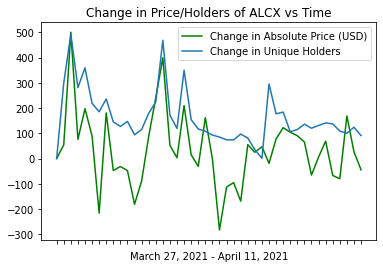

In [8]:
#plot
fig,ax = plt.subplots()
plt.plot(dataset['BALANCE_DAY'],dataset['DELTA_PRICE'],label='Change in Absolute Price (USD)',color='g')
plt.plot(dataset['BALANCE_DAY'],dataset['DELTA_ADDRESSES'],label='Change in Unique Holders')
plt.legend(loc='best')
ax.axes.xaxis.set_ticklabels([])
plt.xlabel('March 27, 2021 - April 11, 2021')
plt.title('Change in Price/Holders of ALCX vs Time')
plt.show()

In [4]:
x = dataset.iloc[:,5].values.reshape(-1,1)
y1 = dataset.iloc[:,1].values.reshape(-1,1)
y2 = dataset.iloc[:,2].values.reshape(-1,1)
linear_reg = LinearRegression()
linear_reg.fit(x,y1)
y_pred = linear_reg.predict(x)
linear_reg2 = LinearRegression()
linear_reg2.fit(x,y2)
y_pred2 = linear_reg2.predict(x)

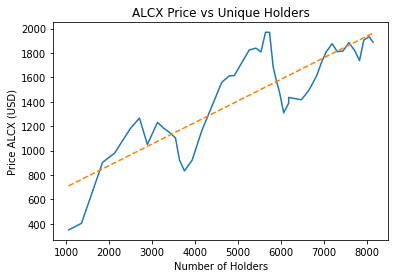

In [7]:
lin_reag3 = LinearRegression()
lin_reag3.fit(y2,y1)
y_pred3 = lin_reag3.predict(y2)
fig,ax = plt.subplots()
plt.plot(dataset['UNIQUE_ADDRESSES'],dataset['PRICE'],label='Unique Addresses')
plt.plot(y2,y_pred3,linestyle='dashed')
plt.xlabel('Number of Holders')
plt.ylabel('Price ALCX (USD)')
plt.title('ALCX Price vs Unique Holders')
plt.show()

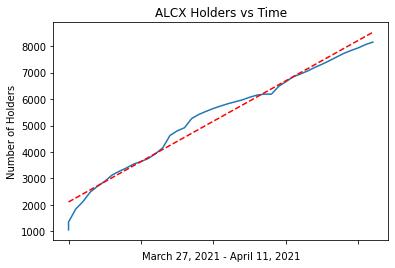

In [10]:
fig,ax = plt.subplots()
plt.plot(x,y2,label='Holders (USD)')
plt.plot(x,y_pred2,color='r',linestyle='dashed')
ax.axes.xaxis.set_ticklabels([])
plt.xlabel('March 27, 2021 - April 11, 2021')
plt.ylabel('Number of Holders')
plt.title('ALCX Holders vs Time')
plt.show()